In [1]:
import numpy as np
import matplotlib
matplotlib.rcParams['image.cmap'] = 'jet'
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time as clock
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import trange
from diffusion_equation import compute_solution
from time import time
from tqdm import trange
import pandas as pd

# Getting data from simulator

In [2]:
# configuration of simulator
# and parametrs of reservouir
perm = np.load('perm.npy')
nx0, nx1 = perm.shape
nx2 = 1
perm = np.reshape(perm, (nx0, nx1, nx2))
poro = 0.1 + np.zeros((nx0, nx1, nx2))

dx0 = 1.0 / nx0
dx1 = 1.0 / nx1
dx2 = 1.0 / nx2

pwat = 2.0
poil = 4.0
vr = 0.3
kwat = 1.0
koil = 0.3

pmin = 0.0
pmax = 1.0

niter = 5000
t_final = 3.0
dt = t_final / niter

In [3]:
nx0, nx1

(64, 64)

In [39]:
# pres, swat, soil = compute_solution(perm, poro,
#                                     dx0, dx1, dx2, t_final, niter,
#                                     pwat, kwat, poil, koil, vr,
#                                     pmin=0.0, pmax=1.0)

# x_list = np.random.randint(size=niter, low=0, high=64)
# y_list = np.random.randint(size=niter, low=0, high=64)
# dt_n = np.random.randint(size=niter, low=0, high=niter)

# # 0 - pres, 1 - swat, 2 - soil
# sim_data = np.zeros((niter, 3))

# # simulation
# for i in trange(niter):
#     sim_data[i, 0] = pres[x_list[i], y_list[i], 0, dt_n[i]]
#     sim_data[i, 1] = swat[x_list[i], y_list[i], 0, dt_n[i]]
#     sim_data[i, 2] = soil[x_list[i], y_list[i], 0, dt_n[i]]

# #   saving data in file
# N = niter
# np.savetxt(f"data_5k_200225/sim_{N}.txt", sim_data)
# np.savetxt(f"data_5k_200225/x_{N}.txt", x_list)
# np.savetxt(f"data_5k_200225/y_{N}.txt", y_list)
# np.savetxt(f"data_5k_200225/t_{N}.txt", dt_n)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 80636.12it/s]


In [4]:
# configuration of simulator
# and parametrs of reservouir
pwat = 2.0
poil = 4.0
vr = 0.3
kwat = 1.0
koil = 0.3


pmin = 0.0
pmax = 1.0
nx0 = 50
nx1 = 30
nx2 = 1
dx0 = 1.0 / nx0
dx1 = 1.0 / nx1
dx2 = 1.0 / nx2
dt = 3.0 / 2000
niter = 2000

poro = 0.1 + np.zeros((nx0, nx1, nx2))
perm = np.ones((nx0, nx1, nx2))

# Read from file

In [5]:
np.random.randint(0, 5000, 2000)

array([2051, 3274, 4367, ..., 4454, 3092, 3319])

In [91]:
# sim_data: pres, swat, soil

# # 2000
# sim_data = np.loadtxt("2000_data/sim_2k.txt", dtype=np.float32)
# x_list = np.loadtxt("2000_data/x_2k.txt", dtype=np.float32)
# y_list = np.loadtxt("2000_data/y_2k.txt", dtype=np.float32)
# t_list = np.loadtxt("2000_data/t_2k.txt", dtype=np.float32)
# sim_data, x_list, y_list, t_list
n_points = 500
sim_r = np.random.randint(0, 5000, n_points)

# 5000
sim_data = np.loadtxt("data_5k_200225/sim_5000.txt", dtype=np.float32)[sim_r]
x_list = np.loadtxt("data_5k_200225/x_5000.txt", dtype=np.float32)[sim_r]
y_list = np.loadtxt("data_5k_200225/y_5000.txt", dtype=np.float32)[sim_r]
t_list = np.loadtxt("data_5k_200225/t_5000.txt", dtype=np.float32)[sim_r]
sim_data, x_list, y_list, t_list

(array([[ 2.6175374e-01, -4.3981121e-35,  1.0000000e+00],
        [ 4.5423537e-01, -4.2923176e-35,  1.0000000e+00],
        [ 8.5310638e-01,  2.2475463e-03,  9.9775243e-01],
        ...,
        [ 7.4929285e-01,  1.9534953e-34,  1.0000000e+00],
        [ 9.6112692e-01,  3.1610554e-01,  6.8389446e-01],
        [ 2.4197875e-01,  2.3195626e-34,  1.0000000e+00]], dtype=float32),
 array([40., 36., 13., ..., 25.,  2., 43.], dtype=float32),
 array([51., 34., 30., ..., 30.,  0., 42.], dtype=float32),
 array([2146.,  266., 2895., ...,  297., 4164.,  926.], dtype=float32))

In [92]:
sim_data.shape

(5000, 3)

# Convert to torch tensor

In [93]:
3 / 5000

0.0006

In [94]:
simulation_data = torch.tensor(sim_data).requires_grad_(True)

x = torch.tensor(x_list * dx0).requires_grad_(True)
y = torch.tensor(y_list * dx1).requires_grad_(True)
t = torch.tensor(t_list * dt).requires_grad_(True)

points = torch.stack((t, x, y), -1).requires_grad_(True)
points, simulation_data

(tensor([[1.2876, 0.6250, 0.7969],
         [0.1596, 0.5625, 0.5312],
         [1.7370, 0.2031, 0.4688],
         ...,
         [0.1782, 0.3906, 0.4688],
         [2.4984, 0.0312, 0.0000],
         [0.5556, 0.6719, 0.6562]], grad_fn=<StackBackward0>),
 tensor([[ 2.6175e-01, -4.3981e-35,  1.0000e+00],
         [ 4.5424e-01, -4.2923e-35,  1.0000e+00],
         [ 8.5311e-01,  2.2475e-03,  9.9775e-01],
         ...,
         [ 7.4929e-01,  1.9535e-34,  1.0000e+00],
         [ 9.6113e-01,  3.1611e-01,  6.8389e-01],
         [ 2.4198e-01,  2.3196e-34,  1.0000e+00]], requires_grad=True))

# Boundary points

In [71]:
pres0_x1_points = torch.stack((t, torch.zeros_like(x), y), -1).requires_grad_(True)
pres1_x1_points = torch.stack((t, torch.ones_like(x), y), -1).requires_grad_(True)
swat0_x1_points = torch.stack((torch.zeros_like(t), x, y), -1).requires_grad_(True)
soil0_x1_points = torch.stack((torch.zeros_like(t), x, y), -1).requires_grad_(True)
u0_x2_points = torch.stack((t, x, torch.zeros_like(y)), -1).requires_grad_(True)
u1_x2_points = torch.stack((t, x, torch.ones_like(y)), -1).requires_grad_(True)

# Model configuration

In [72]:
#define the class PINN
class PINN(nn.Module):
    def __init__(self, input_layer = 3, hidden_layer = 32, number_layers = 8, output_layer = 7):
        super().__init__()
        
        activation2 = nn.Sigmoid
        activation1 = nn.ReLU
        
        self.fcs = nn.Sequential(*
            [
                nn.Linear(input_layer, hidden_layer),
                activation1()
            ]
        )
        
        self.fch = nn.Sequential(*
            [
                nn.Sequential(*
                    [
                        nn.Linear(hidden_layer, hidden_layer),
                        activation1()
                    ]
                ) for _ in range(number_layers - 1)
            ]
        )
        
        self.fce = nn.Linear(hidden_layer, output_layer)
        
        
    def forward(self, x):
        """
        function for updating neural network
        
        return:
            x - vector (pres
                        soil
                        swat
                        uoil_x,  
                        uoil_y,
                        uwat_x,  
                        uwat_y)
        """
        
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        
        return x



# Differentiail equations, Loss function difinition

$$k_{water} = 1, k_{oil} = 0.3$$
$$x = (x_1, x_2)$$
$$ \phi(x) = 0.1 (poro)\\
k(x) = 1 (perm)$$

#### System of equation:

\begin{equation}
    \begin{cases}
        r_1(t, x) = 0.1 \frac{\partial s_{\text{water}}(t, x)}{\partial t} + div(u_{water}) = 0 \\
        r_2(t, x) = 0.1 \frac{\partial s_{\text{oil}}(t, x)}{\partial t} + div(u_{oil}) = 0 \\
        r_{3,x_1}(t, x) = u_{\text{water},x_1} + \frac{\partial P(t, x)}{\partial x_1} = 0 \\
        r_{3,x_2}(t, x) = u_{\text{water},x_2} + \frac{\partial P(t, x)}{\partial x_2} = 0 \\
        r_{4, x_1}(t, x) = u_{\text{oil},x_1} + 0.1 \frac{\partial P(t, x)}{\partial x_1} = 0 \\
        r_{4, x_2}(t, x) = u_{\text{oil},x_2} + 0.1 \frac{\partial P(t, x)}{\partial x_2} = 0 \\
        r_5(t, x) = s_{\text{water}}(t, x) + s_{\text{oil}}(t, x) - 1 = 0 \\
    \end{cases}
\end{equation}

#### Boundary condition
\begin{equation}
    \begin{cases}
        P(t, (0, x_2)) = (1, 1) \\
        P(t, (1, x_2)) = (0, 0) \\
        s_{\text{water}}(0, x) = (0, 0) \\
        s_{\text{oil}}(0, x) = (1, 1) \\
        u_{water/ oil}^{x_2}(t, x)\big|_{x_2=0} = u_{water/ oil}^{x_2}(t, x)\big|_{x_2=1} = 0
    \end{cases}
\end{equation}


#### Loss function:

\begin{equation}
    \label{eq:loss_term_0}
    \mathcal{R}_0(t, x) = r_1(t, x)^2 + r_2(t, x)^2 + r_3(t, x)^2 + r_4(t, x)^2 + r_5(t, x)^2
\end{equation}


\begin{equation}
    \label{eq:loss_term_1}
    \mathcal{R}_1(t, x) = \big(p(t, 0) - 1.0\big)^2 + \big(p(t, 1) - 0.0 \big)^2 + \big( s_{\text{oil}}(0, x) - 1.0 \big)^2 + \big( s_{\text{water}}(0, x) - 0.0 \big)^2
\end{equation}

\begin{split}
        \mathcal{R}_2(t, x) = \big( p_{\text{neural network}}(t, x) - p_{\text{simulation}}(t, x)\big)^2 + \\ + \big( s_{\text{water, neural network}}(t, x) - s_{\text{water, simulation}}(t, x)\big)^2 + \\ + \big( s_{\text{oil, neural network}}(t, x) - s_{\text{oil, simulation}}(t, x)\big)^2
\end{split}

#### Resultant function:

\begin{equation}
    \label{eq:loss_final}
    \mathcal{L} = w_0 \frac{1}{N} \mathcal{R}_0(t_i, x_i) + w_1 \frac{1}{N} \mathcal{R}_1(t_i, x_i) + w_2 \frac{1}{N} \mathcal{R}_2(t_i, x_i)
\end{equation}

# Model training

In [73]:
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

loss0_hist = []
loss1_hist = []
loss2_hist = []

w0_hist = []
w1_hist = []
w2_hist = []

In [75]:
# neural network returns:
# x - vector (pres
#             soil
#             swat
#             uoil_x,  
#             uoil_y,
#             uwat_x,  
#             uwat_y)

# change learning rate if necessary
# optimizer.param_groups[0]['lr'] = 0.0005
perm_vec = perm[list(x_list.astype(int)), list(y_list.astype(int)), -1]
epochs = 10_000
for cur_epoch in trange(epochs):
    optimizer.zero_grad()
    
    model_res = model(points).requires_grad_(True)
    # presseru bound
    press0 = model(pres0_x1_points)[:, 0].requires_grad_(True)
    press1 = model(pres1_x1_points)[:, 0].requires_grad_(True)
    
    # struation boundary
    soil0 = model(soil0_x1_points)[:, 1].requires_grad_(True)
    swat0 = model(swat0_x1_points)[:, 2].requires_grad_(True)
    
    # velocity boundary
    uwat0_x2 = model(u0_x2_points)[:, 4].requires_grad_(True)
    uwat1_x2 = model(u1_x2_points)[:, 4].requires_grad_(True)
    uoil0_x2 = model(u0_x2_points)[:, 6].requires_grad_(True)
    uoil1_x2 = model(u1_x2_points)[:, 6].requires_grad_(True)
    
    one_vector = torch.ones_like(model_res[:, 0])
    zeros_vector = torch.zeros_like(model_res[:, 0])
    
    # functions r(t,x)
    r1 = 0.1 * torch.autograd.grad(model_res[:, 2], t, 
                                   one_vector, 
                                   create_graph=True)[0] +\
    torch.autograd.grad(model_res[:, 5], x, 
                        one_vector, 
                        create_graph=True)[0] +\
    torch.autograd.grad(model_res[:, 6], y, 
                        one_vector, 
                        create_graph=True)[0]
    
    
    r2 = 0.1 * torch.autograd.grad(model_res[:, 1], t, 
                                   one_vector, 
                                   create_graph=True)[0] +\
    torch.autograd.grad(model_res[:, 3], x, 
                        one_vector, 
                        create_graph=True)[0] +\
    torch.autograd.grad(model_res[:, 4], y, 
                        one_vector, 
                        create_graph=True)[0]
    
    
    
    r3_x1 = model_res[:, 5] + (torch.autograd.grad(model_res[:, 0], 
                                                   x, one_vector, 
                                                   create_graph=True)[0])
    
    r3_x2 = model_res[:, 6] + (torch.autograd.grad(model_res[:, 0], 
                                                   y, one_vector, 
                                                   create_graph=True)[0])
    
    r4_x1 = model_res[:, 3] + 0.1 * (torch.autograd.grad(model_res[:, 0], 
                                                         x, one_vector, 
                                                         create_graph=True)[0])
    
    r4_x2 = model_res[:, 4] + 0.1 * (torch.autograd.grad(model_res[:, 0], 
                                                         y, one_vector, 
                                                         create_graph=True)[0])
    
    r5 = model_res[:, 2] + model_res[:, 1] - one_vector
    
    
    # Loss0
    loss0 = torch.mean(r1**2 + r2**2 + r3_x1**2 + r3_x2**2 + 
                       r4_x1**2 + r4_x2**2 + r5**2).requires_grad_(True)
    
    # Loss1
    loss1 = torch.mean((press0 - one_vector)**2 + press1**2 + \
                       (soil0 - one_vector)**2 + swat0**2 +\
                       uwat0_x2**2 + uwat1_x2**2 +\
                       uoil0_x2**2 + uoil1_x2**2).requires_grad_(True)
    
    # Loss2
    loss2 = torch.mean((model_res[:,0] - simulation_data[:,0])**2 + (model_res[:,2] - simulation_data[:,1])**2 + \
                       (model_res[:,1] - simulation_data[:,2])**2).requires_grad_(True)
    

    # algo for weights adjustment
    l1 = loss1.clone().detach().requires_grad_(True)
    l2 = loss2.clone().detach().requires_grad_(True)
    l0 = loss0.clone().detach().requires_grad_(True)
    l1.backward(retain_graph=True)
    l2.backward(retain_graph=True)
    l0.backward(retain_graph=True)
    w0 = abs(l0 / (l0 + l1 + l2))
    w1 = abs(l1 / (l1 + l0 + l2))
    w2 = abs(l2 / (l1 + l0 + l2))
    
    
    # losses history
    loss0_hist.append(loss0.detach().numpy())
    loss1_hist.append(loss1.detach().numpy())
    loss2_hist.append(loss2.detach().numpy())
    
    #weights history
    w0_hist.append(w0.detach().numpy())
    w1_hist.append(w1.detach().numpy())
    w2_hist.append(w2.detach().numpy())
    
    
    loss = w0*loss0 + w1*loss1 + w2*loss2
    dist = loss0 + loss1 + loss2
    loss.backward(retain_graph=True)
    optimizer.step()
    if cur_epoch % 250 == 0:
        print(f'epoch: {cur_epoch}\tloss: {float(dist.detach().numpy()), float(loss0.detach().numpy()), float(loss1.detach().numpy()), float(loss2.detach().numpy())}\t')
#         print(w0, '\t', w1, '\t', w2)

  0%|▏                                                                                                               | 17/10000 [00:00<02:01, 81.85it/s]

epoch: 0	loss: (0.009325936436653137, 0.0009381425334140658, 0.00019144974066875875, 0.00819634459912777)	


  3%|███                                                                                                           | 275/10000 [00:02<01:23, 116.02it/s]

epoch: 250	loss: (0.0258202962577343, 0.008697637356817722, 0.0023135498631745577, 0.014809108339250088)	


  5%|█████▋                                                                                                        | 521/10000 [00:04<01:28, 107.06it/s]

epoch: 500	loss: (0.01410608645528555, 0.00511191226541996, 0.0019297695253044367, 0.007064404897391796)	


  8%|████████▌                                                                                                      | 767/10000 [00:07<01:32, 99.55it/s]

epoch: 750	loss: (0.009980877861380577, 0.003573690541088581, 0.0014488606248050928, 0.004958326928317547)	


 10%|███████████                                                                                                  | 1018/10000 [00:09<01:24, 105.70it/s]

epoch: 1000	loss: (0.008924521505832672, 0.002550496021285653, 0.0015490957302972674, 0.004824929405003786)	


 13%|█████████████▊                                                                                               | 1270/10000 [00:11<01:22, 106.19it/s]

epoch: 1250	loss: (0.008487642742693424, 0.0024554042611271143, 0.0012734578922390938, 0.0047587803564965725)	


 15%|████████████████▌                                                                                            | 1516/10000 [00:14<01:20, 105.38it/s]

epoch: 1500	loss: (0.012822050601243973, 0.006824578158557415, 0.001076102489605546, 0.004921369720250368)	


 18%|███████████████████▍                                                                                          | 1768/10000 [00:16<01:33, 88.29it/s]

epoch: 1750	loss: (0.007852592505514622, 0.0017074861098080873, 0.001520215068012476, 0.004624891094863415)	


 20%|█████████████████████▉                                                                                       | 2015/10000 [00:19<01:18, 101.66it/s]

epoch: 2000	loss: (0.00727145466953516, 0.00139703752938658, 0.0013816268183290958, 0.004492790438234806)	


 23%|████████████████████████▉                                                                                     | 2265/10000 [00:21<01:18, 98.99it/s]

epoch: 2250	loss: (0.0070643918588757515, 0.001277603441849351, 0.0013032065471634269, 0.0044835819862782955)	


 25%|███████████████████████████▎                                                                                 | 2510/10000 [00:24<01:10, 106.82it/s]

epoch: 2500	loss: (0.008949235081672668, 0.00303474860265851, 0.0013158742804080248, 0.004598612431436777)	


 28%|██████████████████████████████▍                                                                               | 2769/10000 [00:26<01:13, 97.92it/s]

epoch: 2750	loss: (0.007208367809653282, 0.0014912027399986982, 0.001196283265016973, 0.004520881921052933)	


 30%|█████████████████████████████████▏                                                                            | 3014/10000 [00:29<01:11, 98.27it/s]

epoch: 3000	loss: (0.00755243469029665, 0.0013877711025997996, 0.001937644905410707, 0.0042270184494555)	


 33%|███████████████████████████████████▌                                                                         | 3266/10000 [00:31<01:00, 111.38it/s]

epoch: 3250	loss: (0.007651730440557003, 0.0017083892598748207, 0.0014696018770337105, 0.004473739303648472)	


 35%|██████████████████████████████████████▋                                                                       | 3514/10000 [00:33<01:06, 96.99it/s]

epoch: 3500	loss: (0.007819733582437038, 0.0019110293360427022, 0.001477034529671073, 0.0044316696003079414)	


 38%|█████████████████████████████████████████▍                                                                    | 3767/10000 [00:36<01:06, 93.15it/s]

epoch: 3750	loss: (0.0075811706483364105, 0.001965506235137582, 0.0005666101933456957, 0.00504905404523015)	


 40%|███████████████████████████████████████████▋                                                                 | 4012/10000 [00:38<00:57, 103.78it/s]

epoch: 4000	loss: (0.007326207123696804, 0.0014970783377066255, 0.0014826185069978237, 0.004346510395407677)	


 43%|██████████████████████████████████████████████▍                                                              | 4266/10000 [00:41<00:55, 103.71it/s]

epoch: 4250	loss: (0.00725830253213644, 0.0014470681780949235, 0.001508317538537085, 0.004302916582673788)	


 45%|█████████████████████████████████████████████████▏                                                           | 4517/10000 [00:43<00:54, 101.51it/s]

epoch: 4500	loss: (0.007295029703527689, 0.0015908461064100266, 0.0011601479491218925, 0.004544035531580448)	


 48%|███████████████████████████████████████████████████▉                                                         | 4769/10000 [00:46<00:48, 107.27it/s]

epoch: 4750	loss: (0.008427766151726246, 0.0022660670801997185, 0.0015676507027819753, 0.004594048485159874)	


 50%|██████████████████████████████████████████████████████▋                                                      | 5013/10000 [00:48<00:47, 105.21it/s]

epoch: 5000	loss: (0.00845918245613575, 0.0024635414592921734, 0.0014551522908732295, 0.004540489055216312)	


 53%|█████████████████████████████████████████████████████████▎                                                   | 5263/10000 [00:51<00:46, 101.88it/s]

epoch: 5250	loss: (0.007950829342007637, 0.0018827738240361214, 0.001761136227287352, 0.004306918941438198)	


 55%|████████████████████████████████████████████████████████████▋                                                 | 5514/10000 [00:53<00:45, 98.74it/s]

epoch: 5500	loss: (0.007317558396607637, 0.0015513746766373515, 0.001316821901127696, 0.004449361935257912)	


 58%|██████████████████████████████████████████████████████████████▉                                              | 5775/10000 [00:56<00:37, 112.34it/s]

epoch: 5750	loss: (0.007678403053432703, 0.0015464568277820945, 0.001561206066980958, 0.004570740275084972)	


 60%|█████████████████████████████████████████████████████████████████▌                                           | 6019/10000 [00:58<00:38, 103.52it/s]

epoch: 6000	loss: (0.006980381440371275, 0.0011812194716185331, 0.0014664840418845415, 0.0043326779268682)	


 63%|████████████████████████████████████████████████████████████████████▎                                        | 6270/10000 [01:00<00:31, 119.29it/s]

epoch: 6250	loss: (0.007293778005987406, 0.0015267400303855538, 0.001412311801686883, 0.004354726057499647)	


 65%|███████████████████████████████████████████████████████████████████████                                      | 6518/10000 [01:03<00:31, 109.63it/s]

epoch: 6500	loss: (0.007665036246180534, 0.0018873332301154733, 0.0012777065858244896, 0.004499996546655893)	


 68%|█████████████████████████████████████████████████████████████████████████▊                                   | 6769/10000 [01:05<00:30, 105.73it/s]

epoch: 6750	loss: (0.007285275962203741, 0.0014609586214646697, 0.0014482955448329449, 0.004376021679490805)	


 70%|████████████████████████████████████████████████████████████████████████████▌                                | 7024/10000 [01:07<00:26, 113.34it/s]

epoch: 7000	loss: (0.011433586478233337, 0.002890460891649127, 0.0015536157879978418, 0.006989509332925081)	


 73%|███████████████████████████████████████████████████████████████████████████████▎                             | 7272/10000 [01:09<00:25, 108.73it/s]

epoch: 7250	loss: (0.007181862369179726, 0.0013993799220770597, 0.0014791871653869748, 0.004303295165300369)	


 75%|█████████████████████████████████████████████████████████████████████████████████▉                           | 7521/10000 [01:12<00:24, 102.55it/s]

epoch: 7500	loss: (0.008165309205651283, 0.00177240080665797, 0.0022480825427919626, 0.00414482643827796)	


 78%|█████████████████████████████████████████████████████████████████████████████████████▍                        | 7765/10000 [01:14<00:22, 97.69it/s]

epoch: 7750	loss: (0.0073633515276014805, 0.001341967610642314, 0.0018007911276072264, 0.00422059278935194)	


 80%|███████████████████████████████████████████████████████████████████████████████████████▍                     | 8017/10000 [01:17<00:19, 102.14it/s]

epoch: 8000	loss: (0.007519269362092018, 0.0014231462264433503, 0.0018872894579544663, 0.004208833444863558)	


 83%|██████████████████████████████████████████████████████████████████████████████████████████                   | 8263/10000 [01:19<00:16, 106.93it/s]

epoch: 8250	loss: (0.007092646788805723, 0.0013844765489920974, 0.0014112751232460141, 0.004296895116567612)	


 85%|█████████████████████████████████████████████████████████████████████████████████████████████▋                | 8517/10000 [01:21<00:14, 99.74it/s]

epoch: 8500	loss: (0.007207303773611784, 0.001251064706593752, 0.00177336810156703, 0.004182870965451002)	


 88%|███████████████████████████████████████████████████████████████████████████████████████████████▍             | 8760/10000 [01:24<00:12, 103.16it/s]

epoch: 8750	loss: (0.01607368513941765, 0.0068292743526399136, 0.0012832395732402802, 0.007961171679198742)	


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████▎          | 9015/10000 [01:26<00:09, 107.25it/s]

epoch: 9000	loss: (0.0074398089200258255, 0.0014648783253505826, 0.0016670720651745796, 0.004307858645915985)	


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████        | 9268/10000 [01:29<00:07, 100.23it/s]

epoch: 9250	loss: (0.00819757953286171, 0.0025414673145860434, 0.0013565514236688614, 0.004299560561776161)	


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 9516/10000 [01:31<00:05, 94.37it/s]

epoch: 9500	loss: (0.0075690858066082, 0.001854496542364359, 0.0012231089640408754, 0.004491480533033609)	


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 9767/10000 [01:34<00:02, 90.53it/s]

epoch: 9750	loss: (0.007136045955121517, 0.0014016216155141592, 0.0014037718065083027, 0.004330652300268412)	


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:36<00:00, 103.29it/s]


In [28]:
def main(model):
    pwat = 2.0
    poil = 4.0
    vr = 0.3
    kwat = 1.0
    koil = 0.3

    # pwat = 1.0
    # poil = 1.0
    # vr = 1.0
    # kwat = 1.0
    # koil = 1.0
    pmin = 0.0
    pmax = 1.0
    nx0 = 50
    nx1 = 30
    nx2 = 1
    dx0 = 1.0 / nx0
    dx1 = 1.0 / nx1
    dx2 = 1.0 / nx2
    dt = 0.26e-1
    niter = 100

    poro = 0.1 + np.zeros((nx0, nx1, nx2))
    perm = np.ones((nx0, nx1, nx2))
    swat = np.zeros((nx0, nx1, nx2))
    soil = np.ones((nx0, nx1, nx2))


    pres, swat, soil = compute_solution(perm, poro,
                                        dx0, dx1, dx2, dt * niter, niter,
                                        pwat, kwat, poil, koil, vr,
                                        pmin=0.0, pmax=1.0)
    
    time_for_model = (niter * dt) * torch.ones(1500)
    x_for_model = dx0 * torch.arange(50)
    y_for_model = dx1 * torch.arange(30)
    cartesian_points = torch.cartesian_prod(x_for_model, y_for_model)
    model_prediction = model(torch.stack((time_for_model, cartesian_points[:, 0], cartesian_points[:, 1]), -1))
    model_prediction = model_prediction.detach().numpy()
    
    
    
    plt.figure()
    plt.title('Water saturation, simulator')
    plt.imshow(swat[:, :, :, -1])
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.savefig('color_swat_sim.png', facecolor='b')
    plt.show()
    
    plt.figure()
    plt.title('Water saturation, PINN')
    plt.imshow(model_prediction[:, 2].reshape(nx0, nx1, nx2))
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.savefig('color_swat_pinn.png')
    plt.show()
    
    plt.figure()
    plt.title('Pressure, simulator')
    plt.imshow(pres[:, :, :, -1])
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.savefig('color_pressure_sim.png')
    plt.show()
    

    plt.figure()
    plt.title('Pressure, PINN')
    plt.imshow(model_prediction[:, 0].reshape(nx0, nx1, nx2))
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.savefig('color_pressure_pinn.png')
    plt.show()    
    
    
    plt.figure()
    plt.title('Насыщенность воды')
    plt.scatter(np.linspace(0.0, 1.0, nx0), swat[:, 0, 0, -1], label='Модель')
    plt.scatter(np.linspace(0.0, 1.0, nx0), model_prediction[:, 2].reshape(nx0, nx1, nx2)[:, 0, 0], label='Симулятор')
    plt.grid()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.savefig('swat_scatter.png')
    plt.show()


    plt.figure()
    plt.title('Pressure')
    plt.scatter(np.linspace(0.0, 1.0, nx0), pres[:, 0, 0, -1], label='Симулятор')
    plt.scatter(np.linspace(0.0, 1.0, nx0), model_prediction[:, 0].reshape(nx0, nx1, nx2)[:, 0, 0], label='Модель')
    plt.grid()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.savefig('pres_scatter.png')
    plt.show()



    return 0

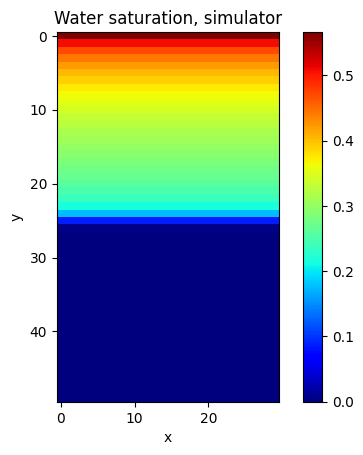

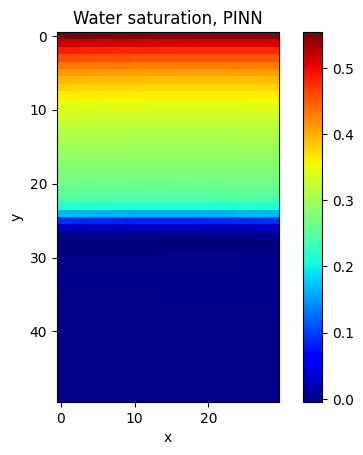

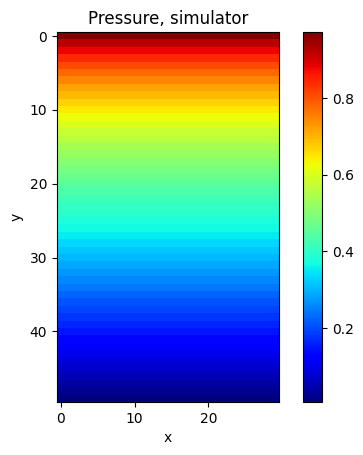

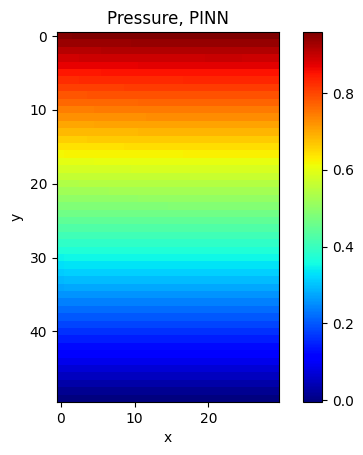

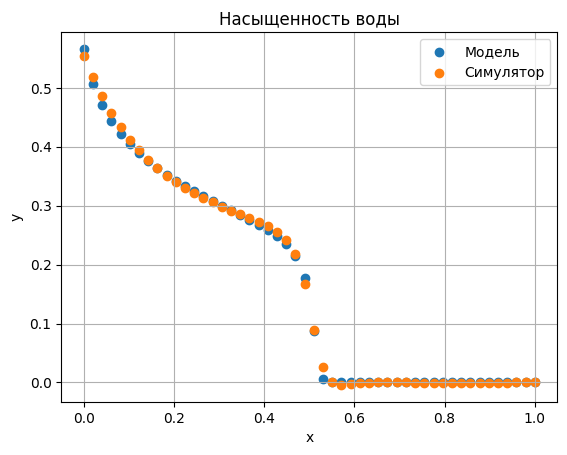

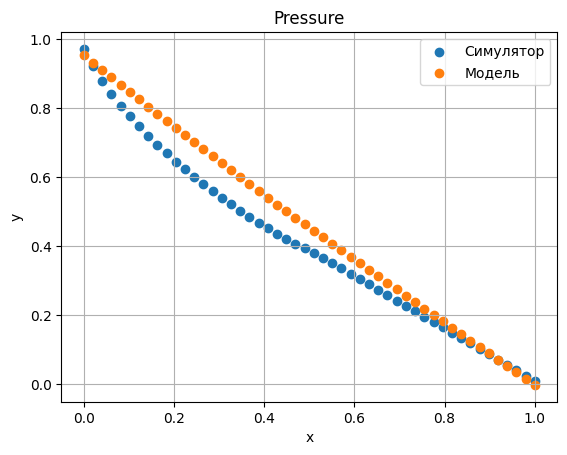

0

In [29]:
main(model)

In [98]:
metrics_train = pd.DataFrame({'Saturation': satur, 'Pressure': pres_train}, index=['MSE', 'MAE', 'R^2', 'RMSE'])

In [99]:
metrics_train

,Saturation,Pressure
MSE,0.000163,0.004363
MAE,0.003605,0.054572
R^2,0.981737,0.961467
RMSE,0.012757,0.066054


In [81]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [95]:
model_pred_train = model(points).detach().numpy()

In [96]:
satur = [mean_squared_error(sim_data[:, 1], model_pred_train[:, 2]),
         mean_absolute_error(sim_data[:, 1], model_pred_train[:, 2]),
         r2_score(sim_data[:, 1], model_pred_train[:, 2]),
         np.sqrt(mean_squared_error(sim_data[:, 1], model_pred_train[:, 2]))]

In [97]:
pres_train = [mean_squared_error(sim_data[:, 0], model_pred_train[:, 0]),
         mean_absolute_error(sim_data[:, 0], model_pred_train[:, 0]),
         r2_score(sim_data[:, 0], model_pred_train[:, 0]),
         np.sqrt(mean_squared_error(sim_data[:, 0], model_pred_train[:, 0]))]

In [ ]:
# x - vector (pres
#             soil
#             swat
#             uoil_x,  
#             uoil_y,
#             uwat_x,  
#             uwat_y)


# 0 - pres, 1 - swat, 2 - soil

In [65]:
def main_new(model):
    perm = np.load('perm.npy')
    nx0, nx1 = perm.shape
    nx2 = 1
    perm = np.reshape(perm, (nx0, nx1, nx2))
    poro = 0.1 + np.zeros((nx0, nx1, nx2))

    dx0 = 1.0 / nx0
    dx1 = 1.0 / nx1
    dx2 = 1.0 / nx2

    pwat = 2.0
    poil = 4.0
    vr = 0.3
    kwat = 1.0
    koil = 0.3

    pmin = 0.0
    pmax = 1.0

    dt = 0.26e-1
    niter = 100


    swat = np.zeros((nx0, nx1, nx2))
    soil = np.ones((nx0, nx1, nx2))


    pres, swat, soil = compute_solution(perm, poro,
                                        dx0, dx1, dx2, dt * niter, niter,
                                        pwat, kwat, poil, koil, vr,
                                        pmin=0.0, pmax=1.0)
    
    time_for_model = (niter * dt) * torch.ones(64 * 64)
    x_for_model = dx0 * torch.arange(64)
    y_for_model = dx1 * torch.arange(64)
    cartesian_points = torch.cartesian_prod(x_for_model, y_for_model)
    model_prediction = model(torch.stack((time_for_model, cartesian_points[:, 0], cartesian_points[:, 1]), -1))
    model_prediction = model_prediction.detach().numpy()
    
    
    
    plt.figure()
    plt.title('Water saturation, simulator')
    plt.imshow(swat[:, :, :, -1])
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.savefig('color_swat_sim.png')
    plt.show()
    
    plt.figure()
    plt.title('Water saturation, PINN')
    plt.imshow(model_prediction[:, 2].reshape(nx0, nx1, nx2))
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.savefig('color_swat_pinn.png')
    plt.show()
    
    plt.figure()
    plt.title('Pressure, simulator')
    plt.imshow(pres[:, :, :, -1])
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.savefig('color_pressure_sim.png')
    plt.show()
    

    plt.figure()
    plt.title('Pressure, PINN')
    plt.imshow(model_prediction[:, 0].reshape(nx0, nx1, nx2))
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.savefig('color_pressure_pinn.png')
    plt.show()    
    
    
    plt.figure()
    plt.title('Water saturation at t = 0')
    plt.scatter(np.linspace(0.0, 1.0, nx0), swat[:, 0, 0, -1], label='Simulator')
    plt.scatter(np.linspace(0.0, 1.0, nx0), model_prediction[:, 2].reshape(nx0, nx1, nx2)[:, 0, 0], label='PINN')
    plt.grid()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.savefig('swat_scatter.png')
    plt.show()


    plt.figure()
    plt.title('Pressure at t = 0')
    plt.scatter(np.linspace(0.0, 1.0, nx0), pres[:, 0, 0, -1], label='Simulator')
    plt.scatter(np.linspace(0.0, 1.0, nx0), model_prediction[:, 0].reshape(nx0, nx1, nx2)[:, 0, 0], label='PINN')
    plt.grid()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.savefig('pres_scatter.png')
    plt.show()



    return 0

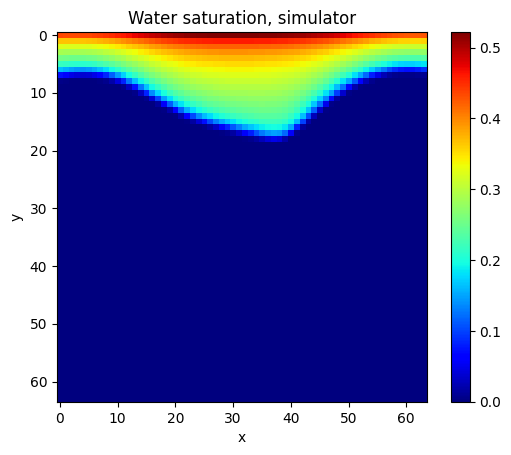

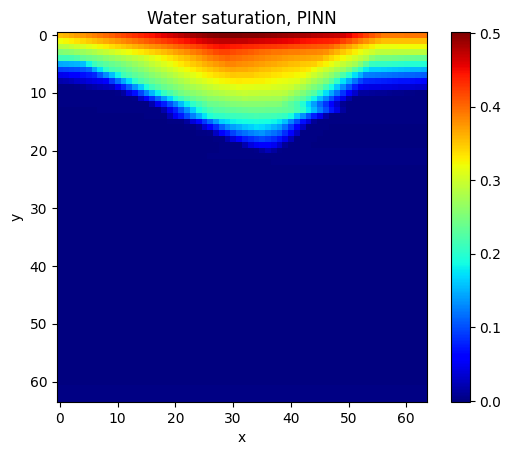

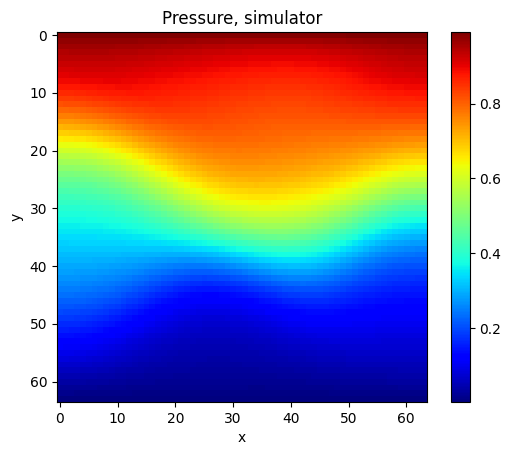

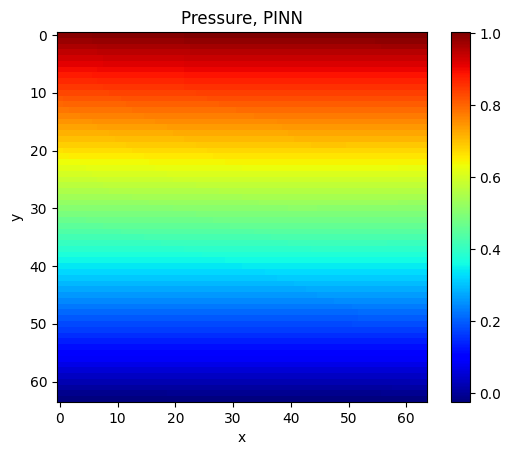

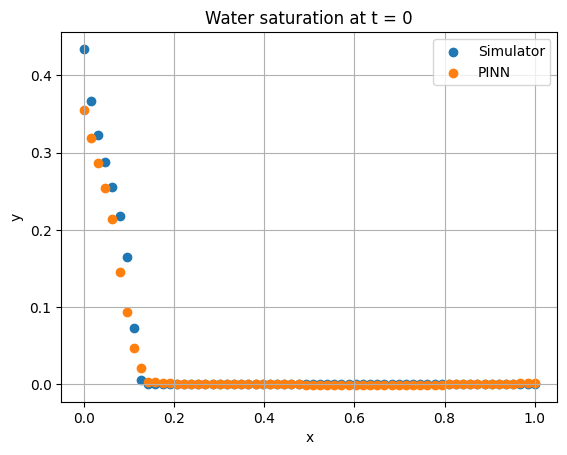

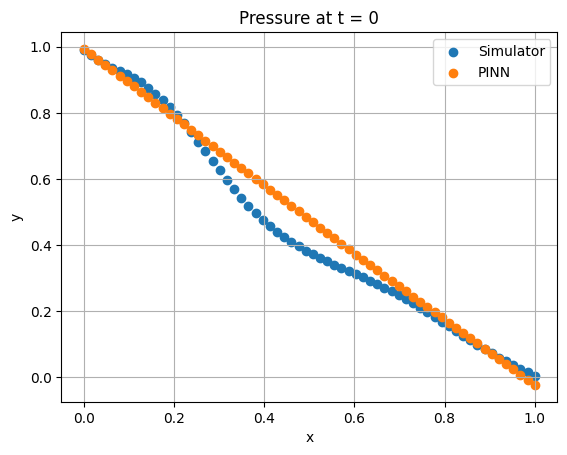

0

In [76]:
main_new(model)